# The Kalman Filter

The Kalman filter is a recursive algorithm for estimating the latent state of a linear dynamical system conditioned on the observations.


## The Linear Dynamical System (LDS)

A (discrete time) linear dynamical system describes the evolution of the state of a system and
the observations that can be obtained from the state.

The system is described at times $t=1,2,\dots$. At each time $t$, the state is denoted by an $N \times 1$ state vector $x_t$. We don't directly observe the states but obtain observations that are related to the states. The observations are denoted by $M \times 1$ observation vector $y_t$. The mathematical model is 

\begin{eqnarray}
x_0 & \sim & {\mathcal N}(\mu, P) \\
x_{t} & = & A x_{t-1} + \epsilon_t \\
y_{t} & = & C x_{t} + \nu_t 
\end{eqnarray}

here, $\epsilon_t$ and $\nu_t$ are assumed to be zero mean Gaussian random variables with variance $Q$ and $P$. 

Equivalently, we can express the system as a hierarchical generative model
\begin{eqnarray}
x_0 & \sim & {\mathcal N}(\mu, P) \\
x_{t}|x_{t-1} & \sim & {\mathcal N}(A x_{t-1}, Q) \\
y_{t}|x_{t} & \sim & {\mathcal N}(C x_{t}, R) 
\end{eqnarray}
for $t=1\dots T$.

Both formulations are equivalent; where the former is more often used in engineering and the latter in statistics. Later, we will describe a few small extensions to the model.

We can try to understand the meaning of each parameter to understand qualitatively what the LDS is doing. The parameters reflect our knowledge about 

* the initial state: $\mu, P$
* the inner working of the system dynamics, the state transition model: $A, Q$
* how the states are observed, the observation model $C, R$ 

The initial state mean $\mu$ is a $N \times 1$ vector, and the initial state covariance $P$ is an $N \times N$ positive semidefinite matrix.
These two parameters reflect our prior knowledge about the initial state of the process: the expected state and the uncertainty around it as characterized by the covariance matrix.

Think of the pair $(\mu, \Sigma)$ defining an ellipse and the initial state $x_0$ is most likely located somewhere in this ellipse.

The state transition matrix $A$ is $N \times N$, and the state transition noise covariance matrix $Q$ is $N \times N$, diagonal, positive semidefinite. The state transition matrix $A$ describes the dynamic behaviour of the linear dynamic system: the system would simply undergo a linear transformation if there was no uncertainty about the dynamics
$$
x_t = A x_{t-1}
$$
The linear dynamic system model also includes an additive noise term that enables us to model random deviations from an exactly deterministic linear transformation. The deviations are assumed to be zero mean and have the covariance matrix $Q$.

Given the previous state $x_{t-1}$ at time $t-1$, think of the pair $(A x_{t-1}, Q)$ defining an ellipse and the current state $x_t$ is most likely located somewhere in this ellipse.

Finally, the observation matrix 

$C$ is $M \times N$, observation matrix
$R$ is $M \times M$ and diagonal, positive semidefinite, observation noise covariance

Example: A point object moving with (almost) constant velocity.





The input to the algorithm are the parameters and a sequence of 
observations $y_t$ for $t=1 \dots T$

$y_t$ is $M \times 1$ 

The output of the algorithm is for $t=1\dots T$

* A sequence of state predictions with

-- Predicted state mean estimate: $m_{t|t-1}$

-- Covariance Matrix: $\Sigma_{t|t-1}$

* A sequence of state estimates with

-- Filtered state estimate: $m_{t|t}$

-- Covariances: $\Sigma_{t|t}$

-- A sequence of loglikelihoods $l_k = p(y_k| y_{1:k-1})$


## The algorithm

The Kalman filtering algorithm is as follows:

### Initialization
The algorithm is initialized by
\begin{eqnarray}
m_{1|0} & = & \mu \\
\Sigma_{1|0} & = & P \\
l_0 & = & 0
\end{eqnarray}


For $t = 1\dots T $

### Update 
\begin{eqnarray}
S_t & = & C \Sigma_{t|t-1} C^\top + R \\
G_t & =& \Sigma_{t|t-1} C^\top S_t^{-1} \\
e_t & = & y_t - C m_{t|t-1} \\ 
m_{t|t} & = & m_{t|t-1} + G_t e_t \\ 
\Sigma_{t|t} & = & \Sigma_{t|t-1} - G_t C \Sigma_{t|t-1} \\ 
l_t & = & l_{t-1} - \frac{1}{2}\log |2\pi S_t| - \frac{1}{2} e_t^\top S_t^{-1} e_t 
\end{eqnarray}

### Prediction

\begin{eqnarray}
m_{t+1|t} & = & A m_{t|t} \\
\Sigma_{t+1|t} & = & A \Sigma_{t|t} A^\top + Q 
\end{eqnarray}

End For

In [24]:
import numpy as np

N = 2
M = 3

A = np.matrix(np.ceil(5*np.random.randn(N,N)))
C = np.matrix(np.ceil(5*np.random.randn(M,N)))
R = np.matrix(2*np.eye(M))
Q = np.matrix(0.1*np.eye(N))

mu = np.matrix(10*np.ones((N,1)))
P = np.matrix(100*np.eye(N))

print('mu=\n',mu)
print('P=\n',P)

print('A=\n',A)
print('C=\n',C)
print('Q=\n',Q)
print('R=\n',R)

T = 3;

y = np.matrix(np.ceil(5*np.random.randn(M,T)))

print('observations=\n',y)

mu=
 [[ 10.]
 [ 10.]]
P=
 [[ 100.    0.]
 [   0.  100.]]
A=
 [[ 12.   4.]
 [  1.  -3.]]
C=
 [[-3.  5.]
 [-4.  2.]
 [ 4. -6.]]
Q=
 [[ 0.1  0. ]
 [ 0.   0.1]]
R=
 [[ 2.  0.  0.]
 [ 0.  2.  0.]
 [ 0.  0.  2.]]
observations=
 [[-1. -5.  6.]
 [ 3. -0. -5.]
 [ 1. -1. -8.]]


## Your Task:

The loglikelihood computation seems to require the inversion of a large matrix and the computation of its determinant. We can circumvent this by 
a simple trick that works when the covariance matrix R is diagonal: we update the state by processing each entry of the observation incrementally.

We replace the update step with simpler operations where only scalar operations are needed.

Consider the observation matrix

\begin{eqnarray}
C & = & \left( \begin{array}{c} c_1 \\ c_2 \\ \vdots \\ c_M \end{array} \right)
\end{eqnarray}
where $c$ are row vectors. For example, if 
$$
C  =  \left( \begin{array}{ccc} 1 & 2 & 4 \\ 3 & 0 & 3 \end{array} \right)
$$
$c_1 = (1,2,4) $ and $c_2 = (3,0,3)$.

Similarly, assume that $R$ is diagonal with
$$
R = \left( \begin{array}{cccc} 
r_1 &     &  &  \\  
    & r_2 &  & \\ 
    & & \ddots  & \\ 
    &  &  & r_M  
\end{array} \right)
$$

 For example, if 
$$
R  =  \left( \begin{array}{ccc} 1 & 0 \\ 0 & 4 \end{array} \right)
$$
$r_1 = 1 $ and $r_2 = 4$.

The new algorithm is as follows
## Kalman Filter with incremental updates

### Initialization
The algorithm is initialized by
$$
m_{1|0}  = \mu 
$$
$$
\Sigma_{1|0}  =  P $$
$$
l_0  =  0
$$


For $t = 1\dots T $ (OuterFor) 
### Update


Define the temporary covariance and mean
$$
W_0 = \Sigma_{t|t-1} 
$$
$$
v_0 = m_{t|t-1} 
$$
$$
\lambda_0 = l_{t-1}
$$

For $i=1 \dots M$ (InnerFor)
$$
S_{t,i}  =  c_i W_{i-1} c_i^\top + r_i \\
$$
$$
G_{t,i}  =  \frac{1}{S_{t,i}} W_{i-1} c_i^\top  \\
$$
$$
e_{t,i}  =  y_t[i] - c_i v_{i-1} \\ 
$$
$$
v_i  =  v_{i-1} + G_{t,i} e_{t,i} \\ 
$$
$$
W_i  =  W_{i-1} - G_{t,i} c_i W_{i-1} \\ 
$$
$$
\lambda_i =  \lambda_{i-1} - \frac{1}{2}\log (2\pi S_{t,i}) - \frac{e_{t,i}^2}{2 S_{t,i}}  
$$
EndInnerfor 

\begin{eqnarray}
\Sigma_{t|t} & = & W_M \\
m_{t|t} & = & v_M \\
l_t & = & \lambda_M
\end{eqnarray}

### Prediction

\begin{eqnarray}
m_{t+1|t} & = & A m_{t|t} \\
\Sigma_{t+1|t} & = & A \Sigma_{t|t} A^\top + Q 
\end{eqnarray}

EndOuterFor

Your task is implementing the Kalman filter with incremental updates as an object in C++.

All the parameters will be specified when constructing the object and observations will be provided to the filter as a $M \times T$ matrix.

In [18]:
A = np.mat('[1, 1; 0, 1]')
C = np.mat('[1, 0]')
Q = 0.01*np.eye(2)
R = 0.01*np.mat('[1]')

mu = np.mat('[0;1]')
P = 0.01*np.eye(2)

y = np.mat('[0, 1, 2.2]')

N = 2
M = 1
T = y.size

Below is a not very efficient and numerically unstable but nevertheless a readable implementation of the Kalman filter for your reference. For or small model sizes $M, N, T$ the results would give a base to test against. Cross check with your implementation that your numerical results are about the same.



In [25]:

m_pred = mu
Sig_pred = P
l = 0

for t in range(T):
    S = C*Sig_pred*C.T + R 
    G = Sig_pred*C.T*(S.I)
    e = y[:,t] - C*m_pred
    m = m_pred + G*e
    Sig = Sig_pred - G*C*Sig_pred
    l = l - 0.5*np.log(np.linalg.det(2*np.pi*S)) - 0.5*e.T*S.I*e
    
    print('m_{}'.format(t+1), '=\n', m)
    print('Sig_{}'.format(t+1), '=\n',Sig)
    print('l_{}'.format(t+1), '=\n',l)
    print('\n')
    
    Sig_pred = A*Sig*A.T + Q
    m_pred = A*m


m_1 =
 [[-1.17370019]
 [-0.92223791]]
Sig_1 =
 [[ 0.28385551  0.20518623]
 [ 0.20518623  0.17907956]]
l_1 =
 [[-12.00699967]]


m_2 =
 [[-0.13598248]
 [-0.3460096 ]]
Sig_2 =
 [[ 0.18609772  0.12142955]
 [ 0.12142955  0.10731049]]
l_2 =
 [[-27.71378147]]


m_3 =
 [[ 1.60290607]
 [ 2.05647302]]
Sig_3 =
 [[ 0.18519405  0.12054427]
 [ 0.12054427  0.10644307]]
l_3 =
 [[-42.23868193]]




For $i=1 \dots M$ (InnerFor)
$$
S_{t,i}  =  c_i W_{i-1} c_i^\top + r_i \\
$$
$$
G_{t,i}  =  \frac{1}{S_{t,i}} W_{i-1} c_i^\top  \\
$$
$$
e_{t,i}  =  y_t[m] - c_i v_{i-1} \\ 
$$
$$
v_i  =  v_{i-1} + G_{t,i} e_{t,i} \\ 
$$
$$
W_i  =  W_{i-1} - G_{t,i} c_i W_{i-1} \\ 
$$
$$
\lambda_i =  \lambda_{i-1} - \frac{1}{2}\log (2\pi S_{t,i}) - \frac{e_{t,i}^2}{2 S_{t,i}}  
$$
EndInnerfor 


In [26]:
m_pred = mu
Sig_pred = P
l = 0

for t in range(T):
    W = Sig_pred
    v = m_pred
    lam = l
    for i in range(M):
        S = C[i,:]*W*C[i,:].T + R[i,i]
        G = W*C[i,:].T/S
        e = y[i,t] - C[i,:]*v
        v = v + G*e
        W = W - G*C[i,:]*W
        lam = lam - 0.5*np.log(2*np.pi*S) - e*e/(2*S)
    Sig = W
    m = v
    l = lam
    
    print('m_{}'.format(t+1), '=\n', m)
    print('Sig_{}'.format(t+1), '=\n',Sig)
    print('l_{}'.format(t+1), '=\n',l)
    print('\n')
    
    Sig_pred = A*Sig*A.T + Q
    m_pred = A*m

m_1 =
 [[-1.17370019]
 [-0.92223791]]
Sig_1 =
 [[ 0.28385551  0.20518623]
 [ 0.20518623  0.17907956]]
l_1 =
 [[-12.00699967]]


m_2 =
 [[-0.13598248]
 [-0.3460096 ]]
Sig_2 =
 [[ 0.18609772  0.12142955]
 [ 0.12142955  0.10731049]]
l_2 =
 [[-27.71378147]]


m_3 =
 [[ 1.60290607]
 [ 2.05647302]]
Sig_3 =
 [[ 0.18519405  0.12054427]
 [ 0.12054427  0.10644307]]
l_3 =
 [[-42.23868193]]




In [7]:
%connect_info


{
  "stdin_port": 63024, 
  "iopub_port": 63023, 
  "signature_scheme": "hmac-sha256", 
  "key": "0f987925-31ca-4947-a769-0a7e43683ebd", 
  "ip": "127.0.0.1", 
  "control_port": 63025, 
  "shell_port": 63022, 
  "transport": "tcp", 
  "hb_port": 63026
}

Paste the above JSON into a file, and connect with:
    $> ipython <app> --existing <file>
or, if you are local, you can connect with just:
    $> ipython <app> --existing kernel-954ded98-c4e9-4d55-8716-719304dc99b7.json 
or even just:
    $> ipython <app> --existing 
if this is the most recent IPython session you have started.


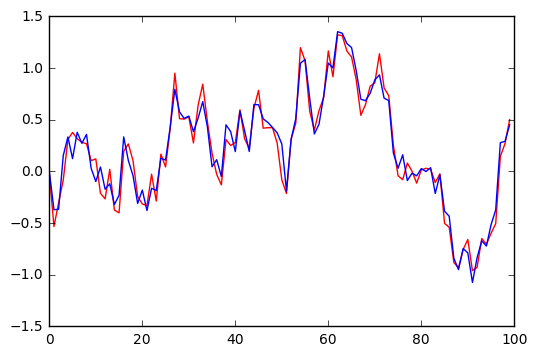

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt 

A = 0.9
C = 1.0

R = 0.01
Q = 0.05

x0 = 0

T = 100

x = np.zeros((T))
y = np.zeros((T))

for t in range(T):
    if t==0:
        x[0] = x0
    else:
        x[t] = A*x[t-1] + np.sqrt(Q)*np.random.randn(1)

    y[t] = C*x[t] + np.sqrt(R)*np.random.randn(1)


    
plt.plot(y,'r')
plt.plot(x,'b')


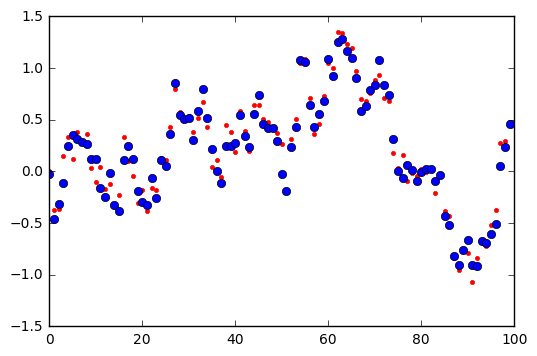

In [2]:

m = np.zeros_like(x)
Sig = np.zeros_like(x)

m0 = 0
Sg0 = 1

for t in range(T):
    if t==0:
        m_pred = A*m0
        SG_pred = A*Sg0*A + Q
    else:
        m_pred = A*m[t-1]
        SG_pred = A*Sig[t-1]*A + Q
    

    Gt = SG_pred*C/(C*SG_pred*C+R)
    m[t] = m_pred + Gt*(y[t]-C*m_pred)
    Sig[t] = SG_pred - Gt*C*SG_pred
    

plt.plot(x,'.r')
plt.plot(m,'ob')
